In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, precision_score, recall_score

In [2]:
notebook_name = '8_classes_EfficientNetV2B1_96x96_bs_256_weighted'

In [3]:
train_dir = '../data/images/train'
val_dir = '../data/images/val'
test_dir = '../data/images/test'

train_df = pd.read_csv('../data/majority_train.csv')
val_df = pd.read_csv('../data/majority_val.csv')
test_df = pd.read_csv('../data/majority_test.csv')

In [4]:
train_df

,filename,class
0,fer0000001.png,neutral
1,fer0000002.png,neutral
2,fer0000004.png,neutral
3,fer0000005.png,neutral
4,fer0000006.png,sadness
...,...,...
25040,fer0028633.png,fear
25041,fer0028634.png,anger
25042,fer0028635.png,sadness
25043,fer0028636.png,neutral


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.05,
    shear_range=np.rad2deg(np.arctan(0.05)),  # used to set the value by fraction instead of an angle
    horizontal_flip=True,
    fill_mode='reflect',
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

target_size = (96, 96)
interpolation = 'bilinear'
color_mode = 'grayscale'
batch_size = 256

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

Found 25045 validated image filenames belonging to 8 classes.
Found 3191 validated image filenames belonging to 8 classes.
Found 3137 validated image filenames belonging to 8 classes.


In [6]:
labels = list(train_generator.class_indices.keys())

In [7]:
labels

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise']

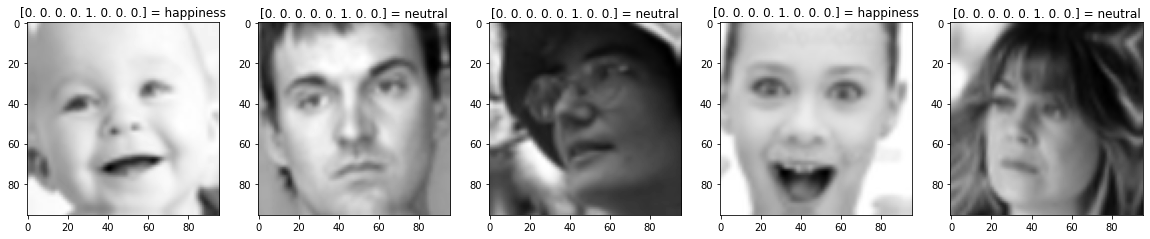

In [8]:
data = next(train_generator)

plt.figure(figsize=[20, 20])

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(f'{data[1][i]} = {labels[np.argmax(data[1][i])]}')
    plt.imshow(data[0][i], cmap='gray')

plt.show()

In [9]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    input_shape=(96, 96, 1),
    weights=None,
    classes=8,
)

In [10]:
model.summary()

Model: "efficientnetv2-b1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 1)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   288         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                                                                                  

 block3a_expand_conv (Conv2D)   (None, 12, 12, 128)  36864       ['block2c_add[0][0]']            
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 12, 12, 128)  512        ['block3a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3a_expand_activation (Act  (None, 12, 12, 128)  0          ['block3a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3a_project_conv (Conv2D)  (None, 12, 12, 48)   6144        ['block3a_expand_activation[0][0]
                                                                 ']                               
          

                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 6, 6, 384)   1536        ['block4b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 6, 6, 384)   0           ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv2 (DepthwiseConv  (None, 6, 6, 384)   3456        ['block4b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4b_b

                                                                                                  
 block4d_bn (BatchNormalization  (None, 6, 6, 384)   1536        ['block4d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 6, 6, 384)   0           ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 384)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_s

 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 6, 6, 672)    0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 6, 6, 112)    75264       ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 6, 6, 112)   448         ['block5b_project_conv[0][0]']   
 lization)

 block5d_project_bn (BatchNorma  (None, 6, 6, 112)   448         ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_add (Add)              (None, 6, 6, 112)    0           ['block5d_project_bn[0][0]',     
                                                                  'block5c_add[0][0]']            
                                                                                                  
 block5e_expand_conv (Conv2D)   (None, 6, 6, 672)    75264       ['block5d_add[0][0]']            
                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 6, 6, 672)   2688        ['block5e_expand_conv[0][0]']    
 ization)                                                                                         
          

 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 6, 6, 672)   0           ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv2 (DepthwiseConv  (None, 3, 3, 672)   6048        ['block6a_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 3, 3, 672)   2688        ['block6a_dwconv2[0][0]']        
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6c_se_reduce[0][0]']      
          

 block6e_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6e_se_reduce[0][0]']      
                                                                                                  
 block6e_se_excite (Multiply)   (None, 3, 3, 1152)   0           ['block6e_activation[0][0]',     
                                                                  'block6e_se_expand[0][0]']      
                                                                                                  
 block6e_project_conv (Conv2D)  (None, 3, 3, 192)    221184      ['block6e_se_excite[0][0]']      
                                                                                                  
 block6e_project_bn (BatchNorma  (None, 3, 3, 192)   768         ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_a

                                                                                                  
 block6g_add (Add)              (None, 3, 3, 192)    0           ['block6g_project_bn[0][0]',     
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 3, 3, 1152)   221184      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 3, 3, 1152)  4608        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 3, 3, 1152)  0           ['block6h_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1280)        0           ['top_activation[0][0]']         
 2D)                                                                                              
                                                                                                  
 top_dropout (Dropout)          (None, 1280)         0           ['avg_pool[0][0]']               
                                                                                                  
 predictions (Dense)            (None, 8)            10248       ['top_dropout[0][0]']            
                                                                                                  
Total params: 6,940,796
Trainable params: 6,869,724
Non-trainable params: 71,072
__________________________________________________________________________________________________


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
  )

In [12]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=10,
    verbose=2,
)

In [13]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=20,
    restore_best_weights=True,
    verbose=2,
)

In [14]:
min_loss_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/min_loss.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=2,
)

In [15]:
max_accuracy_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_accuracy.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [16]:
max_precision_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_precision.h5',
    monitor='val_precision',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [17]:
max_recall_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_recall.h5',
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [18]:
labels

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise']

In [19]:
class_weights = {
    0: 1.0,
    1: 5.0,
    2: 4.0,
    3: 2.0,
    4: 1.0,
    5: 0.75,
    6: 1.0,
    7: 1.0,
}

In [20]:
fit_history = model.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[
        lr_callback,
        early_stop_callback,
        min_loss_callback,
        max_accuracy_callback,
        max_precision_callback,
        max_recall_callback,
    ],
    verbose=2,
)

Epoch 1/300

Epoch 1: val_loss improved from inf to 1.63254, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\min_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.36415, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 1: val_precision improved from -inf to 0.00000, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_precision.h5

Epoch 1: val_recall improved from -inf to 0.00000, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 66s - loss: 2.8525 - accuracy: 0.3058 - precision: 0.2999 - recall: 0.0599 - val_loss: 1.6325 - val_accuracy: 0.3641 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100 - 66s/epoch - 675ms/step
Epoch 2/300

Epoch 2: val_loss did not improve from 1.63254

Epoch 2: val_accuracy did not improve from 0.36415

Epoch 2: val_precision improved from 0.00000 to 0.00613, saving model to ../models/EfficientNetV2B


Epoch 13: val_accuracy improved from 0.65058 to 0.71796, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 13: val_precision improved from 0.75194 to 0.81375, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_precision.h5

Epoch 13: val_recall improved from 0.52147 to 0.62300, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 49s - loss: 0.9853 - accuracy: 0.6813 - precision: 0.7933 - recall: 0.5531 - val_loss: 0.8268 - val_accuracy: 0.7180 - val_precision: 0.8138 - val_recall: 0.6230 - lr: 0.0100 - 49s/epoch - 504ms/step
Epoch 14/300

Epoch 14: val_loss did not improve from 0.82684

Epoch 14: val_accuracy did not improve from 0.71796

Epoch 14: val_precision did not improve from 0.81375

Epoch 14: val_recall did not improve from 0.62300
98/98 - 47s - loss: 0.9349 - accuracy: 0.6969 - precision: 0.7960 - recall: 0.5810 - val_loss: 0.9067 - val_accuracy: 0.6854 - val_pr


Epoch 29: val_accuracy improved from 0.79191 to 0.79285, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 29: val_precision did not improve from 0.83645

Epoch 29: val_recall improved from 0.74365 to 0.75901, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 48s - loss: 0.6153 - accuracy: 0.7940 - precision: 0.8428 - recall: 0.7411 - val_loss: 0.6093 - val_accuracy: 0.7929 - val_precision: 0.8280 - val_recall: 0.7590 - lr: 0.0100 - 48s/epoch - 492ms/step
Epoch 30/300

Epoch 30: val_loss improved from 0.60245 to 0.53881, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\min_loss.h5

Epoch 30: val_accuracy improved from 0.79285 to 0.81479, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 30: val_precision improved from 0.83645 to 0.85130, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_precision.h5


98/98 - 49s - loss: 0.4838 - accuracy: 0.8272 - precision: 0.8570 - recall: 0.7940 - val_loss: 0.5134 - val_accuracy: 0.8280 - val_precision: 0.8505 - val_recall: 0.8060 - lr: 0.0100 - 49s/epoch - 501ms/step
Epoch 46/300

Epoch 46: val_loss did not improve from 0.50797

Epoch 46: val_accuracy did not improve from 0.82795

Epoch 46: val_precision did not improve from 0.85423

Epoch 46: val_recall did not improve from 0.80602
98/98 - 48s - loss: 0.4865 - accuracy: 0.8299 - precision: 0.8631 - recall: 0.7977 - val_loss: 0.5868 - val_accuracy: 0.7894 - val_precision: 0.8169 - val_recall: 0.7675 - lr: 0.0100 - 48s/epoch - 487ms/step
Epoch 47/300

Epoch 47: val_loss improved from 0.50797 to 0.49889, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\min_loss.h5

Epoch 47: val_accuracy did not improve from 0.82795

Epoch 47: val_precision did not improve from 0.85423

Epoch 47: val_recall did not improve from 0.80602
98/98 - 48s - loss: 0.4723 - accuracy: 0.8342 - precis


Epoch 62: val_accuracy improved from 0.84394 to 0.84550, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 62: val_precision did not improve from 0.86304

Epoch 62: val_recall improved from 0.82889 to 0.83077, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 50s - loss: 0.3024 - accuracy: 0.8844 - precision: 0.9004 - recall: 0.8690 - val_loss: 0.4253 - val_accuracy: 0.8455 - val_precision: 0.8624 - val_recall: 0.8308 - lr: 1.0000e-03 - 50s/epoch - 507ms/step
Epoch 63/300

Epoch 63: val_loss did not improve from 0.42532

Epoch 63: val_accuracy improved from 0.84550 to 0.84644, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 63: val_precision improved from 0.86304 to 0.86346, saving model to ../models/EfficientNetV2B1_96x96_256_weighted_manually_2\max_precision.h5

Epoch 63: val_recall did not improve from 0.83077
98/98 - 49s - loss: 0.3011 - accura


Epoch 78: val_accuracy did not improve from 0.85490

Epoch 78: val_precision did not improve from 0.86565

Epoch 78: val_recall did not improve from 0.83986
98/98 - 48s - loss: 0.2605 - accuracy: 0.8990 - precision: 0.9109 - recall: 0.8896 - val_loss: 0.4217 - val_accuracy: 0.8483 - val_precision: 0.8628 - val_recall: 0.8377 - lr: 1.0000e-04 - 48s/epoch - 489ms/step
Epoch 79/300

Epoch 79: val_loss did not improve from 0.42167

Epoch 79: val_accuracy did not improve from 0.85490

Epoch 79: val_precision did not improve from 0.86565

Epoch 79: val_recall did not improve from 0.83986
98/98 - 47s - loss: 0.2558 - accuracy: 0.8989 - precision: 0.9113 - recall: 0.8877 - val_loss: 0.4221 - val_accuracy: 0.8493 - val_precision: 0.8614 - val_recall: 0.8377 - lr: 1.0000e-04 - 47s/epoch - 484ms/step
Epoch 80/300

Epoch 80: val_loss did not improve from 0.42167

Epoch 80: val_accuracy did not improve from 0.85490

Epoch 80: val_precision did not improve from 0.86565

Epoch 80: val_recall did not


Epoch 96: val_recall did not improve from 0.84049
98/98 - 48s - loss: 0.2519 - accuracy: 0.9013 - precision: 0.9107 - recall: 0.8907 - val_loss: 0.4265 - val_accuracy: 0.8511 - val_precision: 0.8657 - val_recall: 0.8405 - lr: 1.0000e-04 - 48s/epoch - 488ms/step
Epoch 97/300

Epoch 97: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

Epoch 97: val_loss did not improve from 0.42033

Epoch 97: val_accuracy did not improve from 0.85490

Epoch 97: val_precision did not improve from 0.86572

Epoch 97: val_recall did not improve from 0.84049
98/98 - 47s - loss: 0.2563 - accuracy: 0.8993 - precision: 0.9094 - recall: 0.8897 - val_loss: 0.4292 - val_accuracy: 0.8518 - val_precision: 0.8638 - val_recall: 0.8386 - lr: 1.0000e-04 - 47s/epoch - 484ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 0.42033

Epoch 98: val_accuracy did not improve from 0.85490

Epoch 98: val_precision did not improve from 0.86572

Epoch 98: val_recall did not improve from 0.84049
98/98 -

In [21]:
def draw_graphics(fit_history, metric_name):
    history = fit_history.history
    
    metric = history[metric_name]
    val_metric = history[f'val_{metric_name}']
    
    epochs = range(1, len(metric) + 1)

    plt.plot(epochs, metric, 'b', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'r', label=f'Validation {metric_name}')
    
    plt.title(f'Training and validation {metric_name}')
    plt.xlabel('epochs')
    plt.ylabel(f'{metric_name}')
    plt.legend()
    plt.show()

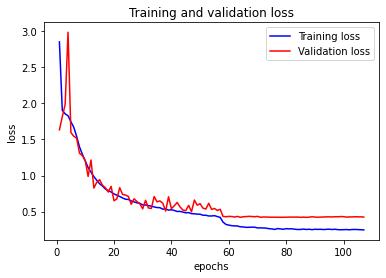

In [22]:
draw_graphics(fit_history, 'loss')

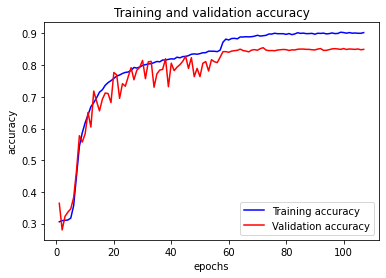

In [23]:
draw_graphics(fit_history, 'accuracy')

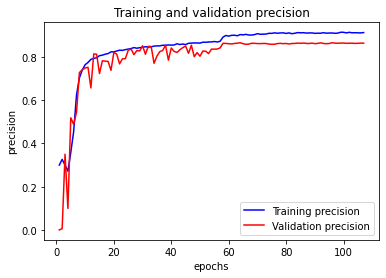

In [24]:
draw_graphics(fit_history, 'precision')

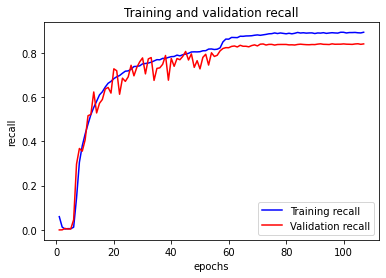

In [25]:
draw_graphics(fit_history, 'recall')

In [26]:
x_test = []
y_test = []

for image_name, emotion in test_df.values:
    image = tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, image_name),
        target_size=target_size,
        interpolation=interpolation,
        color_mode=color_mode,
    )
    
    x_test.append(tf.keras.preprocessing.image.img_to_array(image))
    y_test.append(labels.index(emotion))
        
x_test = np.array(x_test)
y_test = np.array(y_test)

In [27]:
def draw_confusion_matrix(y_true, y_pred, labels):
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    display = ConfusionMatrixDisplay(cm, display_labels=labels)

    _, ax = plt.subplots(figsize=(10, 10))
    display.plot(cmap=plt.cm.Blues, ax=ax)
    plt.show()

In [28]:
def compute_metrics(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 score: {2 * (precision * recall) / (precision + recall) * 100:.2f}%')

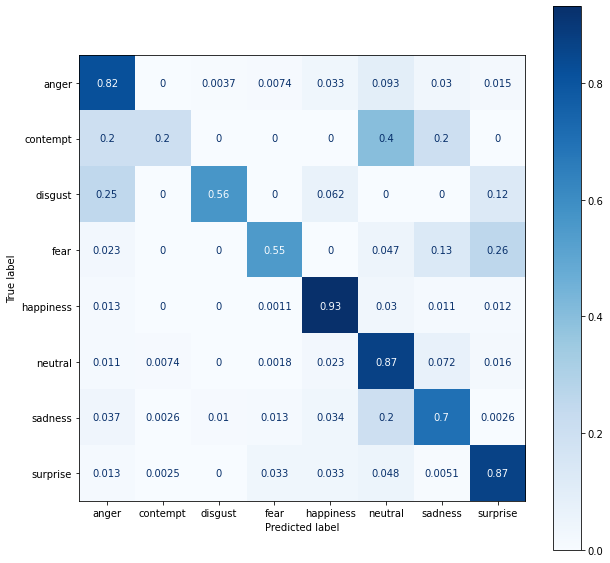

Accuracy: 84.79%
Precision: 71.31%
Recall: 68.68%
F1 score: 69.97%


In [29]:
min_loss_model = tf.keras.models.load_model(f'../models/{notebook_name}/min_loss.h5')
y_pred = min_loss_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

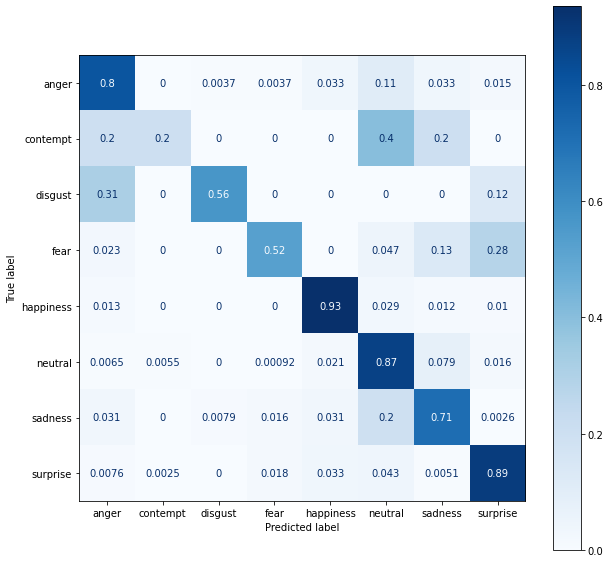

Accuracy: 85.24%
Precision: 73.97%
Recall: 68.75%
F1 score: 71.27%


In [30]:
# best
max_accuracy_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_accuracy.h5')
y_pred = max_accuracy_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

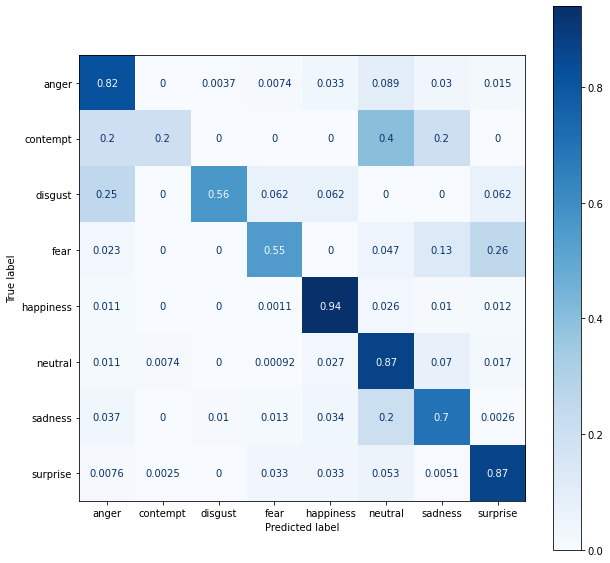

Accuracy: 84.95%
Precision: 71.73%
Recall: 68.77%
F1 score: 70.22%


In [31]:
max_precision_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_precision.h5')
y_pred = max_precision_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

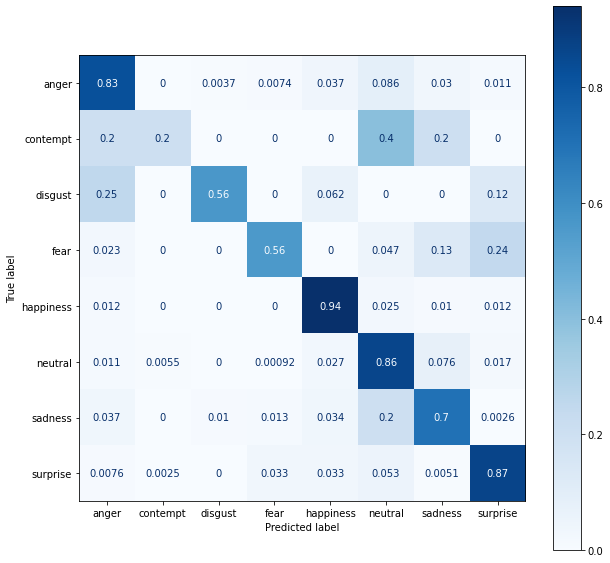

Accuracy: 84.99%
Precision: 72.55%
Recall: 68.99%
F1 score: 70.73%


In [32]:
max_recall_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_recall.h5')
y_pred = max_recall_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)